# News Article Validity Classification

In [10]:
from preprocessing.preprocess import split_data
from models.train import build_model, train_model, tokenize_and_pad
from models.evaluate import evaluate_model
from utils.model_utils import preprocess_text, model_predict
from utils.explain_utils import generate_explanation, word_importance
import matplotlib.pyplot as plt
import json 
import shap
import pandas as pd

In [11]:
#Definition of the path of the xlsx file 
file_path = 'data/fine_data.xlsx'

#Load the xlsx to a dataframe 
df = pd.read_excel(file_path, engine='openpyxl') 

#Show the first couple lines of the dataframe 
print(df.head())

                                             content  label  \
0  XRP Price Prediction Bullish Sentiment Builds ...      0   
1  CoinStats Suffers Major Security Breach 1590 C...      0   
2  TON Ecosystem Faces Phishing Threats Blockchai...      1   
3  Mt Gox to Repay Creditors in BTC and BCH Repay...      1   
4  XRP Tokens in Massive Movement Internal Operat...      1   

                                              reason  score  main topic  
0            This article contains price predictions    NaN         NaN  
1  The article content is too short, no much info...    NaN         NaN  
2  This article is concise and gives good content...    NaN         NaN  
3  This article has a great impact. well writing,...    NaN         NaN  
4  This article is concise and gives good content...    NaN         NaN  


In [12]:
X_train, X_val, y_train, y_val = split_data(df)
print(f'Number of examples in the training set: {len(X_train)}')
print(f'Number of examples in the validation set: {len(X_val)}')

Number of examples in the training set: 76
Number of examples in the validation set: 19


In [13]:
X_train_pad, X_val_pad, tokenizer = tokenize_and_pad(X_train, X_val)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for OOV token
max_length = X_train_pad.shape[1]
model = build_model(max_length, vocab_size)

# Model summary
model.summary()

history = train_model(model, X_train_pad, y_train, X_val_pad, y_val)

c:\Users\rios1\newsArticleValidityClassificationVersion2\env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.4698 - loss: 4.0916 - val_accuracy: 0.4737 - val_loss: 3.8942 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5117 - loss: 3.8517 - val_accuracy: 0.4737 - val_loss: 3.6778 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6164 - loss: 3.6200 - val_accuracy: 0.4737 - val_loss: 3.4719 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5837 - loss: 3.4050 - val_accuracy: 0.4737 - val_loss: 3.2790 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5641 - loss: 3.2217 - val_accuracy: 0.4737 - val_loss: 3.0970 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5446 - loss: 3.0345 - val_accuracy: 0.4737 - val_loss: 2.9253 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5551 - loss: 2.8472 - val_accuracy: 

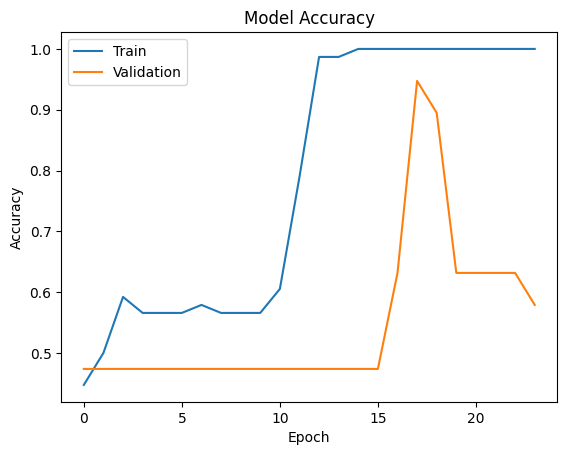

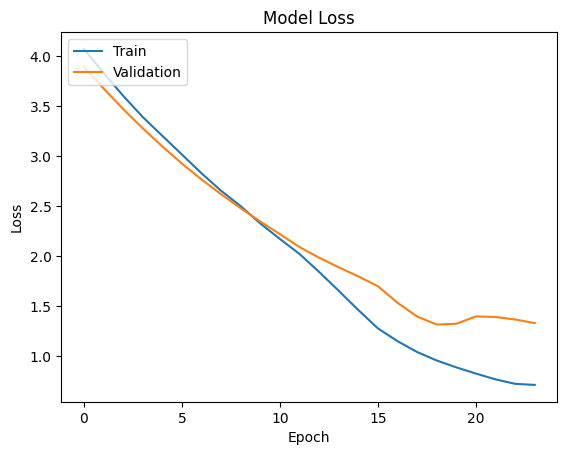

In [14]:
#Evaluate the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
#Evaluate the model's performance
accuracy, precision, recall, f1 = evaluate_model(model, X_val_pad, y_val)
print("Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Model Performance:
Accuracy: 0.8947368421052632
Precision: 0.9
Recall: 0.9
F1-score: 0.9


In [16]:
#Save the training model
model.save('news_article_validity_model.h5')

#Save the tokenizer 
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

print("Model and tokenizer saved with success.")

Model and tokenizer saved with success.


In [18]:
#Define test data
X_test = ["""- Key Points:
 - Ethereum co-founder Vitalik Buterin announced he will donate all proceeds from his cryptocurrency holdings, including Ethereum and Layer 2 tokens, to support the Ethereum ecosystem and broader charitable causes.
 - Buterin will cease investing in new token projects, opting instead for direct donations to valuable initiatives.
 - He stated that all his past sales have funded "various projects that I think are valuable, either within the Ethereum ecosystem or broader charity (eg. biomedical R&D)".
 - Buterin emphasized that his goal is to support undervalued projects, especially in cases where other parts of the ecosystem might overlook them.
 - He believes that having a clear stance on donations increases confidence that he is not part of a plot to manipulate the Ethereum protocol for personal gain.
- Background:
 - Buterin has a history of charitable donations, including a $100 million donation to fund Covid-19 research projects in India.
 - His decision comes after criticism about his previous token sales, which he addressed by stating he hasn't kept proceeds since 2018.
 - The community has mixed reactions, with some questioning his motives and others appreciating his commitment to transparency and charitable causes."""]
X_test_padded = preprocess_text(X_test, tokenizer, max_len=200)

# Create a wrapper function for the model
f = lambda x: model_predict(model, x).flatten()

# Initialize the SHAP explainer
explainer = shap.KernelExplainer(f, X_test_padded[:1000])

# Compute SHAP values
shap_values = explainer.shap_values(X_test_padded)

# Make predictions
predictions = model_predict(model, X_test_padded)

# Print predictions and explanations
for text, pred, shap_vals in zip(X_test, predictions, shap_values):
    # Generate SHAP explanation
    explanation = generate_explanation(text, pred[0], shap_vals, tokenizer)
    print(f"Text: {text}")
    print(f"Explanation (SHAP): {explanation}")
    
    # Compute word importance
    importances = word_importance(text, model, tokenizer)  # Removed max_len argument
    top_words = importances[:5]
    
    validity = "Valid" if pred >= 0.5 else "Invalid"
    print(f"Prediction: {pred[0]:.4f}")
    print(f"Clasificación: {validity}")
    print("Top contributing words:", ", ".join([f"{word} ({val:.6f})" for word, val in top_words]))
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Text: - Key Points:
 - Ethereum co-founder Vitalik Buterin announced he will donate all proceeds from his cryptocurrency holdings, including Ethereum and Layer 2 tokens, to support the Ethereum ecosystem and broader charitable causes.
 - Buterin will cease investing in new token projects, opting instead for direct donations to valuable initiatives.
 - He stated that all his past sales have funded "various projects that I think are valuable, either within the Ethereum ecosystem or broader charity (eg. biomedical R&D)".
 - Buterin emphasized that his goal is to support undervalued projects, especially in cases where other parts of the ecosystem might overlook them.
 - He believes that having a clear stance on donations increases confidence that he is not part of a plot to manipulate the Ethereum protocol for personal gain.
- Background:
 - Buterin has a history of charitable donations, including a $100 million donation to fund Covid-19 research proje

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━